In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create inspector and connect it to the engine
inspector = inspect(engine)
inspector

In [11]:
# Collect the names and types of columns in the measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Collect the names and types of the columns in the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
Base.classes.items()

[('measurement', sqlalchemy.ext.automap.measurement),
 ('station', sqlalchemy.ext.automap.station)]

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


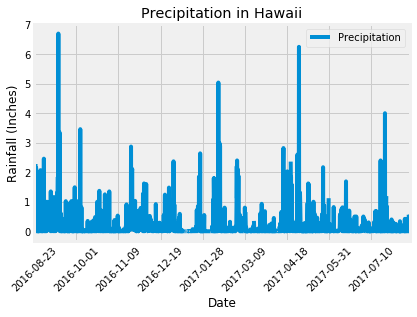

<Figure size 1152x576 with 0 Axes>

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(last_date)

# Calculate the date 1 year ago from the from year before that

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the date and precipitation scores
# And sort the result by date

precip = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).\
                  order_by(Measurement.date).\
                  all())

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip)

# Set date column to index
precip_df.set_index(precip_df['date'], inplace=True)

# Check out first 10 observations of the dataframe
precip_df.head(10)


# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot()

# Label the graph
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(['Precipitation'])
plt.xticks(rotation = '45')
plt.figure(figsize = (16,8))
plt.tight_layout()

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active = [func.min(Measurement.tobs),
               func.max(Measurement.tobs),
               func.avg(Measurement.tobs)]
                
session.query(*most_active).filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

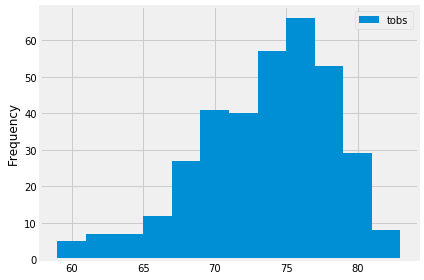

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_station = session.query(Measurement.tobs).\
                                filter(Measurement.station=='USC00519281').\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()

histogram = pd.DataFrame(highest_station, columns=['tobs'])
histogram.plot.hist(bins=12)
plt.tight_layout()

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Using last available year of 2017 to plan for 2020 trip

arrive_date = dt.date(2017, 6, 6)
depart_date = dt.date(2017, 6, 13)
one_year_ago = dt.timedelta(days=365)
previous_start = arrive_date - one_year_ago
previous_depart = depart_date - one_year_ago

t_min, t_avg, t_max = calc_temps(previous_start.strftime("%Y-%m-%d"), previous_depart.strftime("%Y-%m-%d"))[0]
print(t_min, t_avg, t_max)

69.0 75.13461538461539 80.0


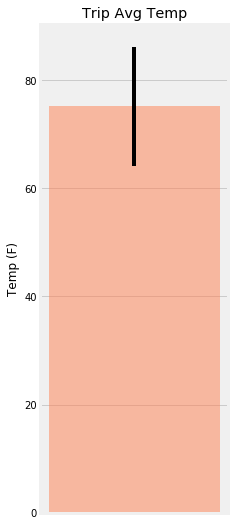

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


# Define Y Error Bar and X
yerr = t_max - t_min
x = 1

# Define Plot
fig, ax = plt.subplots(figsize=(3, 9))

# Plot attributes
ax.bar(x, t_avg, yerr=yerr, alpha= 0.5, color='coral')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')

# Display plot
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

rain_per_station = session.query(*sel).\
                   filter(Measurement.station == Station.station).\
                   filter(Measurement.date >= arrive_date).\
                   filter(Measurement.date <= depart_date).\
                   group_by(Station.name).\
                   order_by(func.sum(Measurement.prcp).\
                   desc()).all()
print(rain_per_station)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.17), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.8599999999999999), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.1300000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.04), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.55), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.13999999999999999), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
